In [2]:
from utils import *
from envs import *
from model import *
import numpy as np
from copy import deepcopy
import argparse
import pandas as pd
import ast
parser = argparse.ArgumentParser()
parser.add_argument('--episodes', type=int, required=False, help='episodes', default=1)
parser.add_argument('--tmax', type=int, required=False, help='tmax', default=100)

parser.add_argument('--goalcoords', type=float,nargs='+', required=False, help='goalcoords', default=[0.5])
parser.add_argument('--rsz', type=float, required=False, help='rsz', default=0.05)
parser.add_argument('--rmax', type=int, required=False, help='rmax', default=5)

parser.add_argument('--seed', type=int, required=False, help='seed', default=2020)
parser.add_argument('--pcinit', type=str, required=False, help='pcinit', default='uni')
parser.add_argument('--npc', type=int, required=False, help='npc', default=32)
parser.add_argument('--alpha', type=float, required=False, help='alpha', default=1.0)
parser.add_argument('--sigma', type=float, required=False, help='sigma', default=0.05)

parser.add_argument('--plr', type=float, required=False, help='plr', default=0.01)
parser.add_argument('--clr', type=float, required=False, help='clr', default=0.01)
parser.add_argument('--llr', type=float, required=False, help='llr', default=0.000) 
parser.add_argument('--alr', type=float, required=False, help='alr', default=0.000) 
parser.add_argument('--slr', type=float, required=False, help='slr', default=0.000)
parser.add_argument('--gamma', type=float, required=False, help='gamma', default=0.9)
parser.add_argument('--nact', type=int, required=False, help='nact', default=2)

parser.add_argument('--balpha', type=float, required=False, help='balpha', default=0.0)
parser.add_argument('--paramsindex', type=int,nargs='+', required=False, help='paramsindex', default=[0,1,2])
parser.add_argument('--noise', type=float, required=False, help='noise', default=0.000)

parser.add_argument('--datadir', type=str, required=False, help='datadir', default='./data/')
parser.add_argument('--figdir', type=str, required=False, help='figdir', default='./fig/')
parser.add_argument('--csvname', type=str, required=False, help='csvname', default='results')
args, unknown = parser.parse_known_args()


# training params
train_episodes = args.episodes
tmax = args.tmax

# env pararms
envsize = 1
maxspeed = 0.1
goalsize = args.rsz
startcoord = [-0.75]
goalcoords = args.goalcoords
seed = args.seed
initvelocity = 0.0
max_reward = args.rmax

#agent params
npc = args.npc
sigma = args.sigma
alpha = args.alpha
nact = args.nact

# noise params
noise = args.noise
paramsindex = args.paramsindex
piname = ''.join(map(str, paramsindex))
pcinit = args.pcinit

actor_eta = args.plr
critic_eta = args.clr
pc_eta = args.llr
sigma_eta = args.slr
constant_eta = args.alr
etas = [pc_eta, sigma_eta,constant_eta, actor_eta,critic_eta]
gamma = args.gamma
balpha = args.balpha

In [3]:
def plot_density(logparams, trials, ax=None, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.025, envsize=1, color='k'):
    if ax is None:
        f,ax = plt.subplots()
    xs = np.linspace(-1,1,1001)

    for trial in trials:
        pcacts = predict_batch_placecell(logparams[trial], xs)
        dx = np.sum(pcacts,axis=1)
        ax.plot(xs, dx, label=f'T={trial}',color=color)

    ax.set_xlabel('Location (x)')
    ax.set_ylabel('Density $d(x)$')
    ax.legend(frameon=False, fontsize=6)


skip
skip
skip


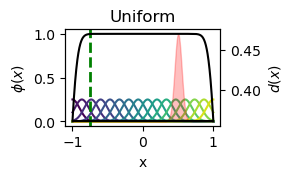

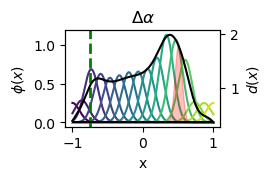

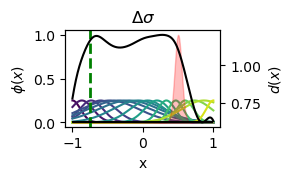

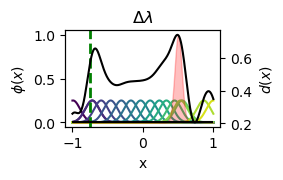

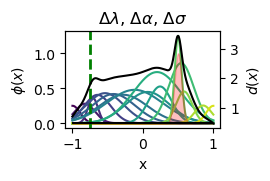

In [4]:
# plot example field 
ltypes = [0.0, 0.0001]
pcinit = 'uni'
names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
for llr in ltypes:
    for slr in ltypes:
        for alr in ltypes:

            try:
                [logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_{pcinit}_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")
                
                name_components = []
                if llr > 0:
                    name_components.append(names_dict['llr'])
                if alr > 0:
                    name_components.append(names_dict['alr'])
                if slr > 0:
                    name_components.append(names_dict['slr'])
                name = ', '.join(name_components) if name_components else 'Uniform'
                
                f,ax = plt.subplots(figsize=(2,1.25))
                plot_pc(logparams, trial=-1,ax=ax, goalsize=0.05)
                ax.set_ylabel('$\phi(x)$')
                ax.set_xlabel('x')
                ax.set_title(name)
                ax.legend().set_visible(False)

                ax2 = ax.twinx()
                plot_density(logparams, [50000], ax=ax2, goalsize=0.05)
                ax2.set_ylabel('$d(x)$')
                ax2.legend().set_visible(False)
                
                f.savefig(f'./fig/1D_{pcinit}_{name}.svg')

            except FileNotFoundError: print('skip')



(50000, 16)
(50000, 16, 1)
(50000, 16, 2)


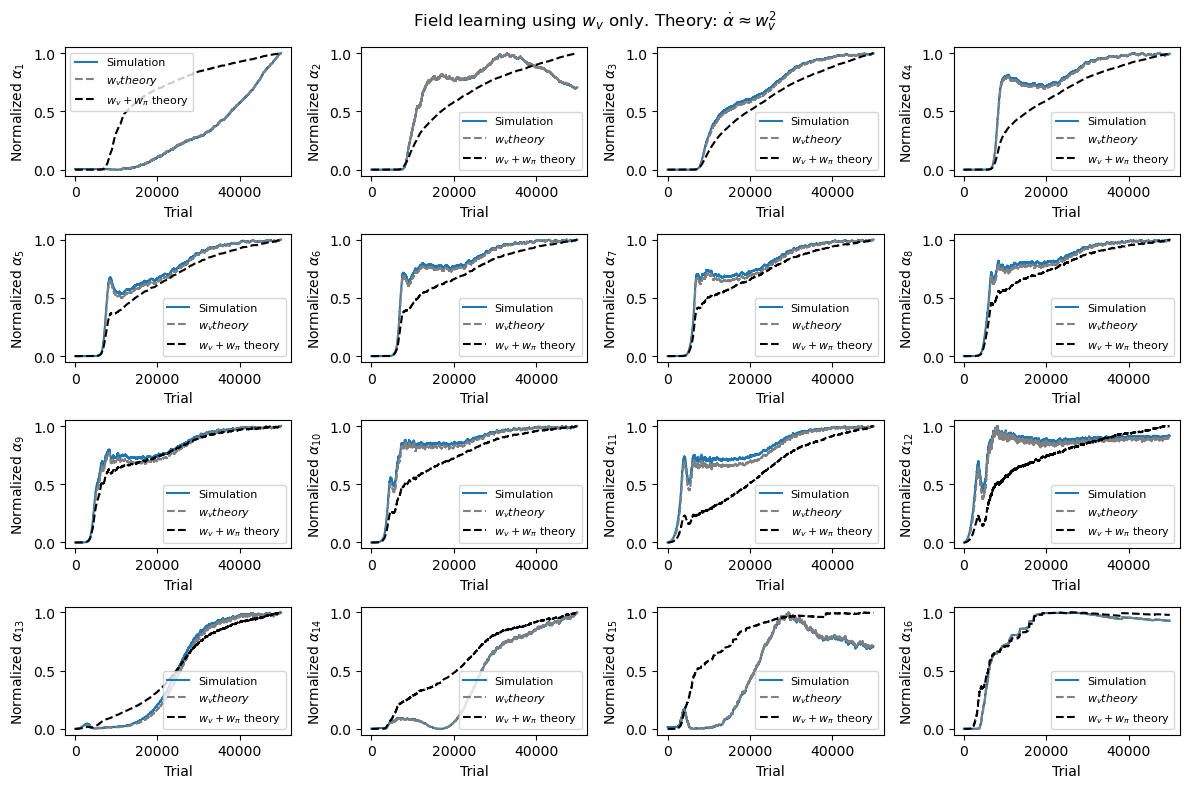

In [5]:
def normalize_values(x):
    maxval = np.max(x)
    minval = np.min(x)
    return (x-minval)/(maxval-minval)

# theory vs simulation
llr = 0.000
slr = 0.000
alr = 0.0001
total_trials = 50000
num = 100
[logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/wv_1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_uni_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")


lambdas = []
sigmas = []
alphas = []
policys = []
values = []
episodes = np.arange(total_trials)
for e in episodes:
    lambdas.append(logparams[e][0])
    sigmas.append(logparams[e][1])
    alphas.append(logparams[e][2])
    policys.append(logparams[e][3])
    values.append(logparams[e][4])
lambdas = np.array(lambdas)
sigmas = np.array(sigmas)
alphas = np.array(alphas)
policys = np.array(policys)
values = np.array(values)

print(alphas.shape)
print(values.shape)
print(policys.shape)

trial_max = 50000
f,ax = plt.subplots(4,4, figsize=(12,8))
f.suptitle('Field learning using $w_v$ only. Theory: $\dot\\alpha \\approx w_v^2$')
ax = ax.flatten()
for n in np.arange(16):
    sim = normalize_values(alphas[:trial_max,n])
    half_theory = normalize_values((values[:trial_max,n,0]**2))
    theory = normalize_values((values[:trial_max,n,0]**2 + np.sum(policys[:trial_max,n]**2,axis=1)))

    ax[n].plot(np.arange(trial_max), sim)
    ax[n].plot(np.arange(trial_max), half_theory, linestyle='--',color='gray')
    ax[n].plot(np.arange(trial_max), theory, linestyle='--',color='k')

    ax[n].plot([],[],label='Simulation',color='tab:blue')
    ax[n].plot([],[],linestyle='--', label='$w_v theory$',color='gray')
    ax[n].plot([],[], linestyle='--',label='$w_v + w_\pi$ theory',color='k')

    # diff = abs(sim-theory)
    # plt.plot(np.arange(trial_max), diff)
    i = n+1
    ax[n].set_ylabel(f'Normalized $\\alpha_{{{i}}}$')
    ax[n].set_xlabel('Trial')
    ax[n].legend(fontsize=8)

f.tight_layout()
# ax = plt.twinx()
# ax.plot(np.arange(trial_max), moving_average(latencys,100)[:trial_max], color='tab:orange')
# ax.set_ylabel('Latency')


(50000, 16)
(50000, 16, 1)
(50000, 16, 2)


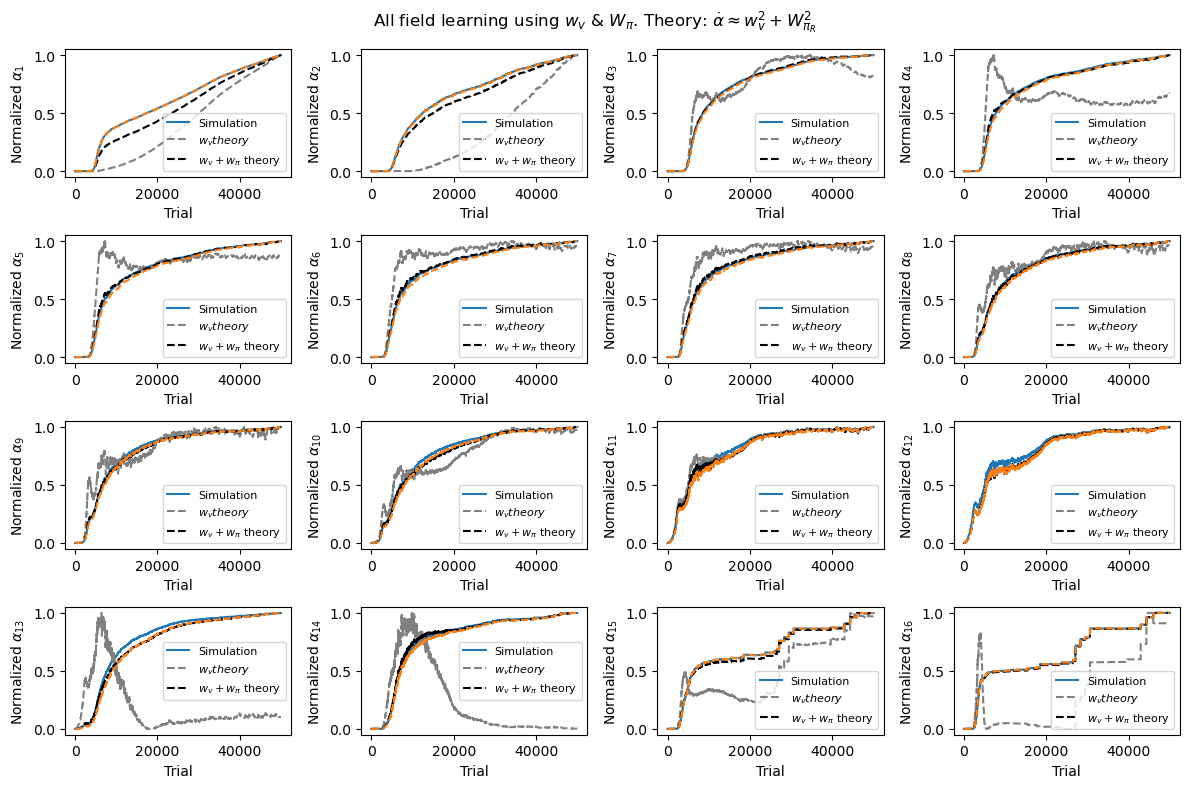

In [7]:
# theory vs simulation
llr = 0.0001
slr = 0.0001
alr = 0.0001
total_trials = 50000
num = 100
[logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_uni_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")


lambdas = []
sigmas = []
alphas = []
policys = []
values = []
episodes = np.arange(total_trials)
for e in episodes:
    lambdas.append(logparams[e][0])
    sigmas.append(logparams[e][1])
    alphas.append(logparams[e][2])
    policys.append(logparams[e][3])
    values.append(logparams[e][4])
lambdas = np.array(lambdas)
sigmas = np.array(sigmas)
alphas = np.array(alphas)
policys = np.array(policys)
values = np.array(values)

print(alphas.shape)
print(values.shape)
print(policys.shape)

trial_max = 50000
f,ax = plt.subplots(4,4, figsize=(12,8))
f.suptitle('All field learning using $w_v$ & $W_{\pi}$. Theory: $\dot\\alpha \\approx w_v^2 + W_{\pi_R}^2$')
ax = ax.flatten()
for n in np.arange(16):
    sim = normalize_values(alphas[:trial_max,n])
    half_theory = normalize_values((values[:trial_max,n,0]**2))
    theory = normalize_values((values[:trial_max,n,0]**2 + policys[:trial_max,n,0]**2))
    theory2 = normalize_values((values[:trial_max,n,0]**2 + np.sum(policys[:trial_max,n]**2,axis=1)))

    ax[n].plot(np.arange(trial_max), sim)
    ax[n].plot(np.arange(trial_max), half_theory, linestyle='--',color='gray')
    ax[n].plot(np.arange(trial_max), theory, linestyle='--',color='k')
    ax[n].plot(np.arange(trial_max), theory2, linestyle='--',color='tab:orange')

    ax[n].plot([],[],label='Simulation',color='tab:blue')
    ax[n].plot([],[],linestyle='--', label='$w_v theory$',color='gray')
    ax[n].plot([],[], linestyle='--',label='$w_v + w_\pi$ theory',color='k')

    # diff = abs(sim-theory)
    # plt.plot(np.arange(trial_max), diff)
    i = n+1
    ax[n].set_ylabel(f'Normalized $\\alpha_{{{i}}}$')
    ax[n].set_xlabel('Trial')
    ax[n].legend(fontsize=8)

f.tight_layout()
# ax = plt.twinx()
# ax.plot(np.arange(trial_max), moving_average(latencys,100)[:trial_max], color='tab:orange')
# ax.set_ylabel('Latency')


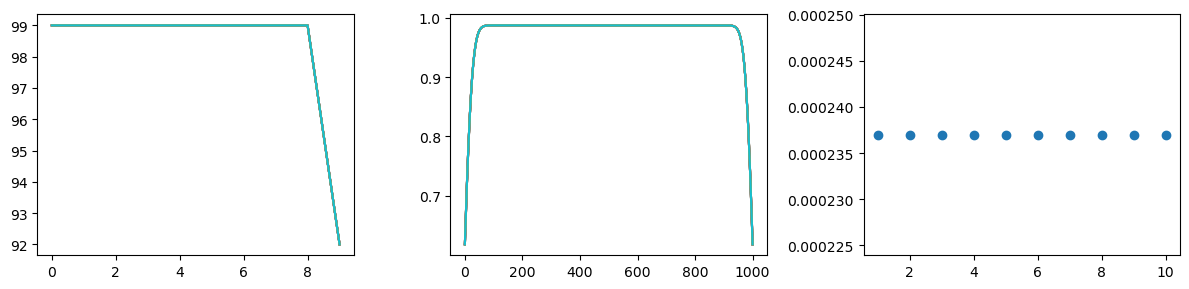

In [62]:
episodes = 10
latencys, cumr, dxs, delta_dxrs = saveload(f"./comp_data/rmax_compile_{episodes}e", 1, 'load')

rmaxs = [1,2,3,4,5,6,7,8,9,10]
f,ax = plt.subplots(1,3,figsize=(12,3))
for r,rmax in enumerate(rmaxs):
    ax[0].plot(latencys[r], label=rmax)
    ax[1].plot(dxs[r,-1], label=rmax)

ax[2].scatter(rmaxs, delta_dxrs[:,-1])

f.tight_layout()


In [86]:
for n in np.arange(16):
    a = alphas[:trial_max,n]
    v = (values[:trial_max,n,0]**2 + policys[:trial_max,n,0]**2)
    df = v/a
    print(np.mean(df), np.max(df), np.min(df))

0.020496971548129326 0.0386152229222505 2.87930769180222e-10
0.9872957765807117 1.606180184471813 2.749348349866011e-10
3.7256016552738838 4.912110352446709 3.158649057478239e-11
5.00298735391637 6.599469363700329 5.160085319219062e-12
6.042117227979086 7.782960359704223 2.366025731520422e-10
6.2571797553018085 7.803981945725316 7.948261612797113e-11
6.06589345931041 7.449563101288576 7.825275486049347e-10
7.659309422205038 9.58031320248799 3.1202574703516207e-10
6.788099879768528 8.36704004631971 1.3346601123735072e-10
9.024313084503152 11.31921923161694 7.631792595037086e-11
20.362679101385588 23.97093997312396 1.954349133519747e-10
27.273641773892315 32.540584778438806 3.0274680340503675e-10
18.15654162599974 22.62638729996819 1.64685567819304e-10
6.155687439153912 7.637166931141287 1.5113745547442566e-10
0.17677577909985004 0.26408467544391134 8.216487979789463e-11
0.004097360244169908 0.006331717810223581 4.3193763382202675e-11


[0.1        0.1        0.1        ... 0.11391853 0.11391885 0.11391916]
0.0999999999990814 0.1139191645792953
9.816939459545867e-13 0.0558662867895338
[0.1        0.1        0.1        ... 0.15793696 0.15793539 0.15793381]
0.09999999997767411 0.1644706517327694
1.2753618967618866e-11 1.5959180968742759
[0.1        0.1        0.1        ... 0.16541657 0.1654158  0.16541503]
0.09999999999991206 0.1692291646386438
3.6692246444780186e-10 4.489162170653176
[0.1        0.1        0.1        ... 0.21891915 0.21891833 0.21891753]
0.09999999999826131 0.2213505825072979
1.0447026408314896e-10 5.807360471479794
[0.1        0.1        0.1        ... 0.40539154 0.40539808 0.40540462]
0.09999999999957822 0.40560386590203795
1.4068971581017655e-11 7.358787885938509
[0.1        0.1        0.1        ... 0.44301228 0.44302631 0.44304029]
0.09999999999252368 0.4449538632799957
1.5822170074699032e-11 10.548964106861954
[0.1        0.1        0.1        ... 0.42739151 0.42741449 0.42743738]
0.099999999999

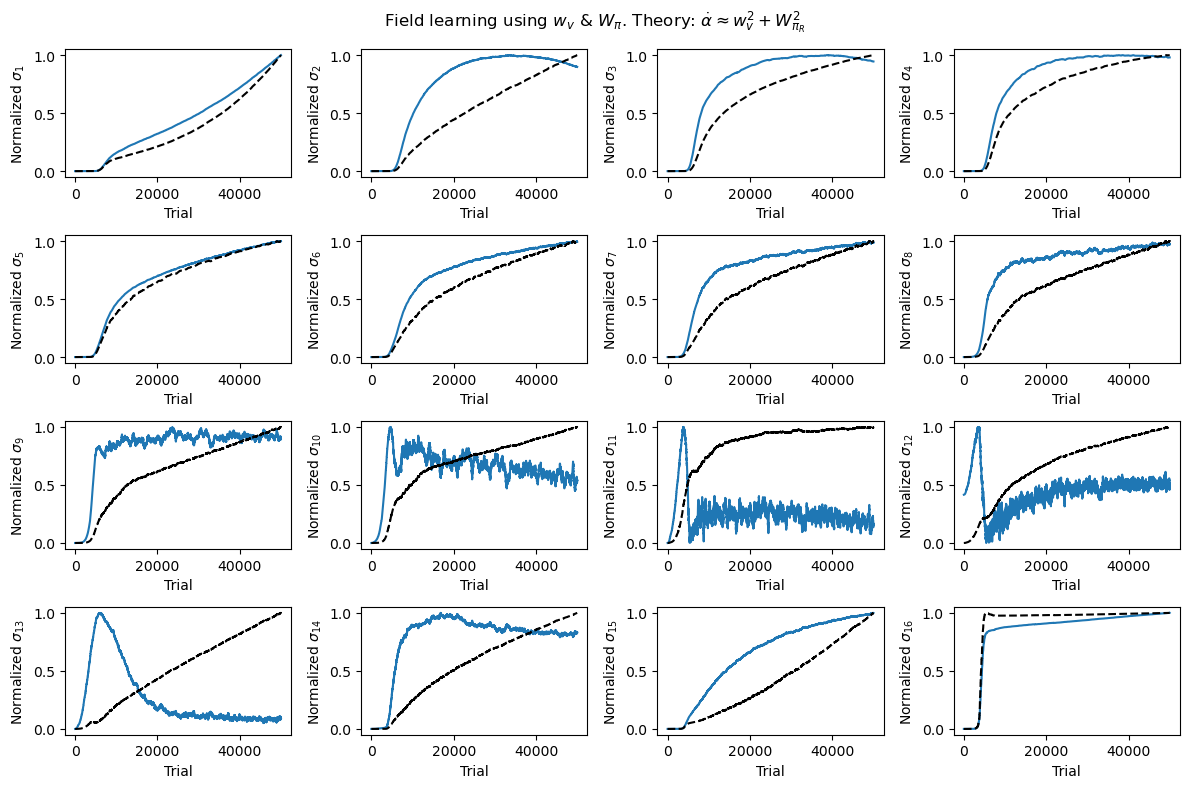

In [82]:
# theory vs simulation
llr = 0.000
slr = 0.0001
alr = 0.000
total_trials = 50000
num = 100
[logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_uni_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")


lambdas = []
sigmas = []
alphas = []
policys = []
values = []
episodes = np.arange(total_trials)
for e in episodes:
    lambdas.append(logparams[e][0])
    sigmas.append(logparams[e][1])
    alphas.append(logparams[e][2])
    policys.append(logparams[e][3])
    values.append(logparams[e][4])
lambdas = np.array(lambdas)
sigmas = np.array(sigmas)
alphas = np.array(alphas)
policys = np.array(policys)
values = np.array(values)

trial_max = 50000
f,ax = plt.subplots(4,4, figsize=(12,8))
f.suptitle('Field learning using $w_v$ & $W_{\pi}$. Theory: $\dot\\alpha \\approx w_v^2 + W_{\pi_R}^2$')
ax = ax.flatten()
for n in np.arange(16):
    
    print(sigmas[:trial_max,n])
    sim = sigmas[:trial_max,n]
    # half_theory = normalize_values((values[:trial_max,n,0]**2))
    theory = (values[:trial_max,n,0]**2 + policys[:trial_max,n,0]**2)

    ax[n].plot(np.arange(trial_max), normalize_values(sim))
    # ax[n].plot(np.arange(trial_max), half_theory, linestyle='--',color='gray')
    ax[n].plot(np.arange(trial_max), normalize_values(theory), linestyle='--',color='k')

    # ax[n].plot([],[],label='Simulation',color='tab:blue')
    # ax[n].plot([],[],linestyle='--', label='$w_v theory$',color='gray')
    # ax[n].plot([],[], linestyle='--',label='$w_v + w_\pi$ theory',color='k')

    # diff = abs(sim-theory)
    # plt.plot(np.arange(trial_max), diff)
    i = n+1
    ax[n].set_ylabel(f'Normalized $\\sigma_{{{i}}}$')
    ax[n].set_xlabel('Trial')
    # ax[n].legend(fontsize=8)

f.tight_layout()
# ax = plt.twinx()
# ax.plot(np.arange(trial_max), moving_average(latencys,100)[:trial_max], color='tab:orange')
# ax.set_ylabel('Latency')
